In [118]:
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import random
from scipy.signal import find_peaks, peak_widths
import random
import elm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_digits, load_diabetes, make_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np


In [120]:
X = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/X_v3.csv', delimiter=',')
Y = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/Targets_v3.csv', delimiter=',')
w1= np.arange(0,3848,1)
w2=np.arange(0,101,1)
w3=np.linspace(1,101,101)
y= Y[:,0]
dP1 = []
dP2 = []
dP3 = []
dA1 = []
dA2 = []
dA3 = []
dQ1 = []
dQ2 =[]
dQ3= []
pos1 = []
pos2 = []
pos3 = []
x_2p_data= pd.DataFrame()
y_2p_data = pd.DataFrame()

In [121]:
stdsc = StandardScaler()

In [122]:
for i in w1:
    peaks, _ = find_peaks(Y[i,:],height=0.4)
    if len(peaks)==1:
      dP1.append(peaks)
      dA1.append(Y[i,(peaks[0])])
      j = peak_widths(Y[i,:], peaks, rel_height=0.5)
      dQ1.append(j[0])
      pos1.append(i)  
    if len(peaks)==2:
        dP2.append(peaks)
        dA2.append(Y[i,(peaks[0],peaks[1])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ2.append(j[0])
        pos2.append(i) 
    if len(peaks)==3:
        dP3.append(peaks)
        dA3.append(Y[i,(peaks[0],peaks[1],peaks[2])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ3.append(j[0])
        pos3.append(i)

In [123]:
len(dQ2)

2087

In [124]:
y_2p_wav = []

                                                                                                                            
#getting full waveform for 2 peaks responses
for i in range(0,len(pos2)):
    j = pos2[i]
    y_2p_wav.append(Y[j,:])

In [125]:
y_2p_wav = np.array(y_2p_wav)

In [126]:
z = pd.DataFrame(y_2p_wav)

In [127]:
y_2p_wav.shape

(2087, 101)

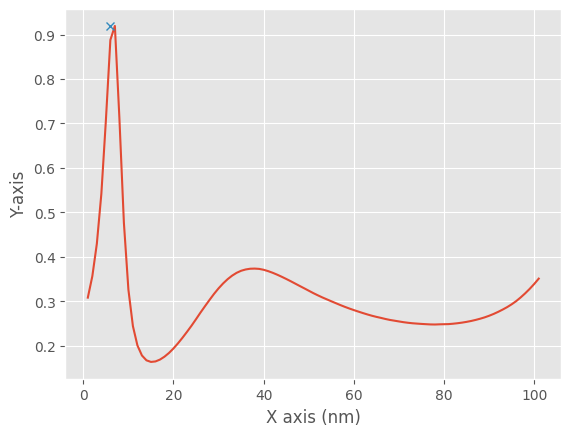

In [128]:
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w3,Y[8,:])
    plt.plot(dP1[1], dA1[1], "x")
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()

In [129]:
x_2p_data = pd.DataFrame()
#getting data for each peak response by taking X as different pos values for each 1,2,3 peak response
for i in range(0,len(pos2)):
    j = pos2[i]
    k = pd.DataFrame({"P1":X[j,0],"H1":X[j,1],"H2":X[j,2],"H3":X[j,3],"W1":X[j,4]},index=[i])
    x_2p_data = pd.concat([x_2p_data, pd.DataFrame(k)], ignore_index=True)


In [130]:
y_2p_data = pd.DataFrame()
#getting data for each peak response by taking y as different pos values for each 1,2,3 peak response

for i in range(0,len(pos2)):
    m = pd.DataFrame({"Peak 1":dP2[i][0],"Peak 2":dP2[i][1],"Amp P1":dA2[i][0],"Amp P2":dA2[i][1],"Q-Factor P1":(dP2[i][0]/dQ2[i][0]),"Q-Factor P2":(dP2[i][1]/dQ2[i][1])},index=[i])
    y_2p_data = pd.concat([y_2p_data, pd.DataFrame(m)], ignore_index=True)

In [136]:

y_2p_data_107 = pd.concat([z,y_2p_data],axis=1)

In [138]:
x = x_2p_data.to_numpy()
y = y_2p_data.to_numpy()



In [148]:
# %% [markdown]
# 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# %%

# %%
x= x_2p_data.to_numpy()
y = y_2p_data.to_numpy()

# Load CSV files


# Extract input and output data

#print(f"input data:{X}, output data: {y}")

# Normalize/Standardize input data
scaler = StandardScaler()
X = scaler.fit_transform(x)
#print(f"input data after fit transform(mean and standard deviation -> scale and center): {X}")

# Convert to PyTorch tensors

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define the neural network
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0]),
            nn.GELU()
        ])
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.extend([
                nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]),
                nn.GELU()
            ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Define the input, hidden, and output sizes
input_size = X.shape[1]
hidden_sizes = [32, 64, 128, 64,32]  # Adjust the number of neurons and layers as needed
output_size = y.shape[1]

# Create an instance of the neural network
model = MyNeuralNetwork(input_size, hidden_sizes, output_size)
print(model)
# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adaptive Moment Estimation

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {loss.item():.4f}')


# %%
# Set the model to evaluation mode
model.eval()

# Make predictions on new data
with torch.no_grad():
    new_data = X_test.clone().detach().requires_grad_(True)
    test_predictions  = model(new_data)

# Convert predictions to numpy array if needed
predictions_np = test_predictions.numpy()

# Evaluate the model on the test set
test_loss = criterion(test_predictions, y_test)
print(f'Test MSE: {test_loss.item():.4f}')

# %%




MyNeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): GELU(approximate='none')
  )
  (output_layer): Linear(in_features=32, out_features=6, bias=True)
)
Epoch [100/1000], MSE: 50.9613
Epoch [200/1000], MSE: 40.8613
Epoch [300/1000], MSE: 36.2926
Epoch [400/1000], MSE: 22.5557
Epoch [500/1000], MSE: 17.7716
Epoch [600/1000], MSE: 15.5028
Epoch [700/1000], MSE: 14.1161
Epoch [800/1000], MSE: 12.5467
Epoch [900/1000], MSE: 11.0960
Epoch [1000/1000], MSE: 9.8330
Test MSE: 16.5633


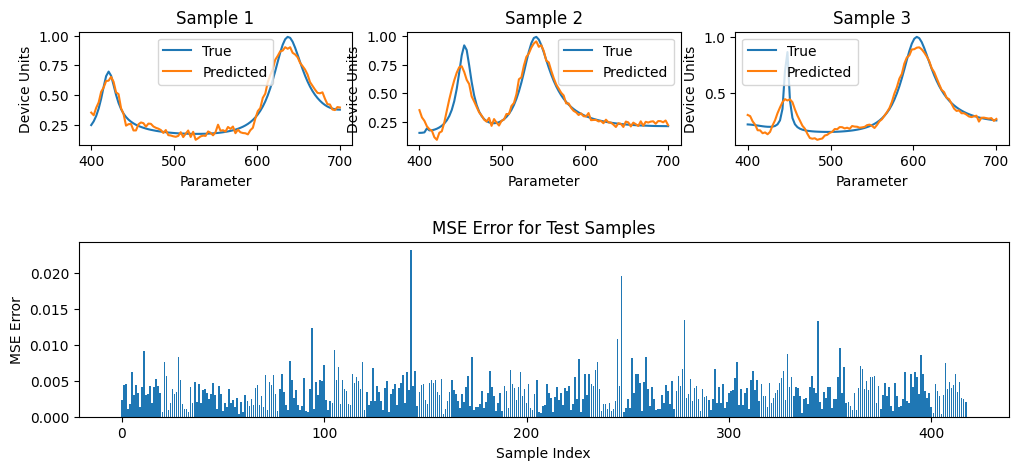

In [147]:
import matplotlib.pyplot as plt
import numpy as np

#y_test = y_test[:,0:101]
#test_predictions = test_predictions[:,0:101]

# Plot the optical response for a few samples

num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(400,700,101))
wavelengths = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.plot(wavelengths, y_test[i], label='True')
    plt.plot(wavelengths, test_predictions[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Parameter')
    plt.ylabel('Device Units')
    plt.legend()
# Plot the MSE error for each sample
mse_errors = torch.mean((test_predictions - y_test)**2, dim=1)

plt.subplot(2, 1, 2)
plt.bar(range(len(mse_errors)), mse_errors)
plt.xlabel('Sample Index')
plt.ylabel('MSE Error')
plt.title('MSE Error for Test Samples')

#plt.tight_layout()
plt.show()


In [205]:
import tensorflow as tf
import torch
from scipy import optimize
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, Reshape#, MaxPooling1D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x = x_2p_data.to_numpy()
Y = y_2p_data.to_numpy()

Ypeaks = Y[:,0:2]
Yamp = Y[:,2:4]
Yqfac= Y[:,4:6]

scalerP = MinMaxScaler()
scalerQ = MinMaxScaler()

scalerP.fit(Ypeaks)
scalerQ.fit(Yqfac)

Yamp = np.concatenate([Yamp,scalerQ.transform(Yqfac)],axis=1)

Ypeaks= np.concatenate([scalerP.transform(Ypeaks),Yamp],axis=1)


# Assuming X and Y are your feature and target matrices respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x,Ypeaks, test_size=0.2, random_state=42)


# Now X_test contains the testing data
# You can use this X_test to evaluate your trained model

# Create a Sequential model
model = Sequential()

# Add the input layer and the first hidden layer
model.add(Dense(64, input_shape=(5,), activation='relu'))  # Assuming 64 neurons in the first hidden layer

# Add additional hidden layers if needed
model.add(Dense(20, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model.add(Dense(20, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model.add(Dense(20, activation='relu'))  # Example of adding another hidden layer

# Add the output layer
model.add(Dense(6, activation='linear'))  # Assuming 5 design parameters, using linear activation

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using mean squared error as the loss function

# Print a summary of the model
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32)  # Replace X_train and Y_train with your actual training data


# Make predictions
predictions = model.predict(X_test)  # Replace X_test with your actual test data

import matplotlib.pyplot as plt
import numpy as np

# Plot the optical response for a few samples

y_testp = y_test[:,0:2]
predictionsp = predictions[:,0:2]

y_testA = y_test[:,2:4]
predictionsA = predictions[:,2:4]



NameError: name 'x_2p_data' is not defined

In [373]:
for len(Y

print(ind(Y[:,,11))

(2087, 6)

In [175]:
y_testq = y_test[:,4:6]
predictionsq = predictions[:,4:6]


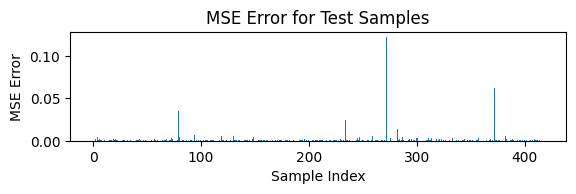

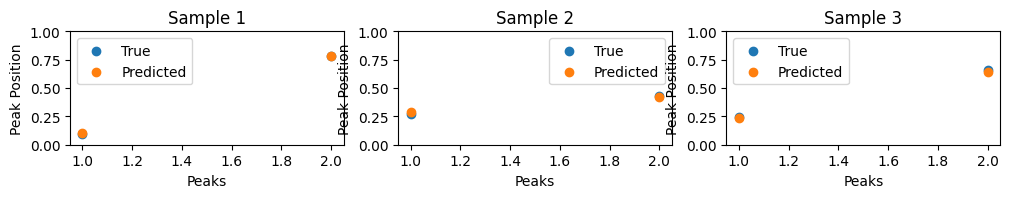

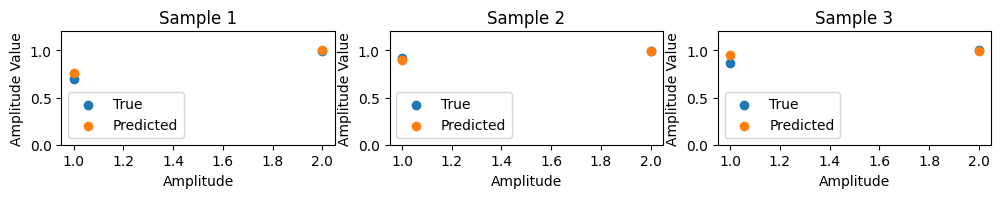

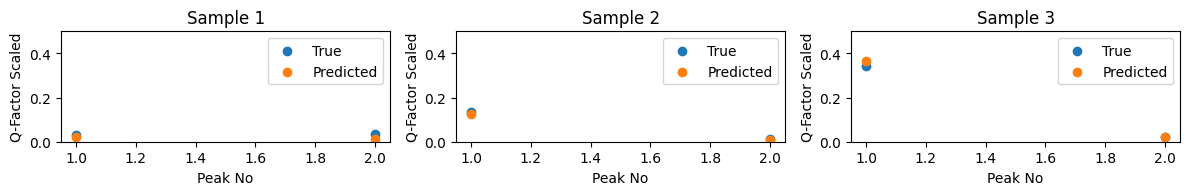

Text(0.5, 1.0, 'MSE Error for Test Samples')

In [181]:


num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))



for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testp[i], label='True')
    plt.scatter(Parameters, predictionsp[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peaks')
    plt.ylabel('Peak Position')
    plt.ylim(0, 1)
    plt.legend()


num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testA[i], label='True')
    plt.scatter(Parameters, predictionsA[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Amplitude')
    plt.ylabel('Amplitude Value')
    plt.ylim(0, 1.2)
    plt.legend()

num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testq[i], label='True')
    plt.scatter(Parameters, predictionsq[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peak No')
    plt.ylabel('Q-Factor Scaled')
    plt.ylim(0, 0.5)
    plt.legend()


# Plot the MSE error for each sample


    
plt.tight_layout()
plt.show()

# Plot the MSE error for each sample
mse_errors = ((predictions - y_test)**2).mean(axis=1)

plt.subplot(3, 1, 3)
plt.bar(range(len(mse_errors)), mse_errors)
plt.xlabel('Sample Index')
plt.ylabel('MSE Error')
plt.title('MSE Error for Test Samples')


In [342]:
from scipy.optimize import minimize
# l-bfgs-b algorithm local optimization of a convex function

x0 = X_test[2,:]
y_true = y_test[2,:]

def objective_function(x):
    # Predict using the model
    y_pred = model.predict(np.array([x]))
    # Calculate mean squared error
    mse = np.mean((y_true - y_pred)**2)
    return mse
    
minimum = minimize(objective_function, x0)

1/1 [==============================] - 0s 54ms/step


In [482]:

for i in range(2087):
    if (Y[i,2]==0.862677747383712):
        print("Yess", i)

Yess 382


In [483]:
Y[382,:]

array([16.        , 68.        ,  0.86267775,  0.99870814,  7.08523512,
        4.98130306])

In [500]:
y_2p_data_107.to_numpy()
y_2p_data_107

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,Peak 1,Peak 2,Amp P1,Amp P2,Q-Factor P1,Q-Factor P2
0,0.446011,0.745741,0.938967,0.548209,0.301717,0.204925,0.162328,0.140873,0.128905,0.121565,...,0.346923,0.347124,0.347528,0.348208,2,60,0.938967,0.526095,1.105929,2.627877
1,0.398317,0.434455,0.487233,0.569577,0.691948,0.830913,0.881422,0.774561,0.612386,0.483269,...,0.208485,0.206181,0.204190,0.202476,6,43,0.881422,0.954840,1.409738,3.589834
2,0.210613,0.203901,0.201097,0.199952,0.199305,0.198622,0.197505,0.196145,0.194654,0.192809,...,0.534476,0.507482,0.483374,0.461836,40,85,0.969771,0.969355,9.000845,6.916008
3,0.302530,0.289028,0.278507,0.271393,0.267905,0.268490,0.273776,0.285668,0.307105,0.342708,...,0.356270,0.353801,0.351368,0.349026,13,67,0.756571,0.494990,3.232556,2.704478
4,0.131013,0.130776,0.130779,0.131026,0.131439,0.132006,0.132617,0.133473,0.134670,0.136045,...,0.636346,0.619823,0.603863,0.588559,34,85,0.608593,0.817603,3.442149,5.534335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,0.230900,0.249488,0.332186,0.307811,0.247348,0.223231,0.209760,0.200403,0.193222,0.187204,...,0.266760,0.262146,0.257883,0.253961,21,72,0.767164,0.957727,9.157710,5.581929
2083,0.133930,0.134715,0.135945,0.137664,0.139822,0.142434,0.145413,0.149005,0.153361,0.158335,...,0.375544,0.370805,0.366250,0.361909,28,68,0.463779,0.779861,2.218038,3.566206
2084,0.298961,0.329465,0.379388,0.451849,0.543391,0.632708,0.678107,0.653408,0.579783,0.495746,...,0.570672,0.548921,0.529654,0.512724,6,84,0.678107,0.963656,1.052814,6.336041
2085,0.243260,0.244592,0.245287,0.247399,0.251658,0.258962,0.270382,0.288215,0.315811,0.358002,...,0.266549,0.266789,0.267266,0.268055,13,56,0.757218,0.625307,2.627743,2.693516


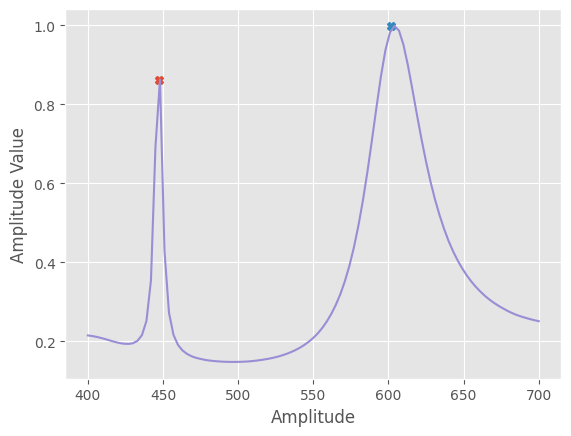

In [513]:
    W1=np.linspace(400,700,101)

    y1= y_2p_data_107.to_numpy()

    with plt.style.context('ggplot'):
        plt.plot(400+47.5247525, 0.86267775, "X")
        plt.plot(400+201.9802, 0.99870814, "X")
        plt.plot(W1,y1[382,0:101])
 #   plt.scatter(W1, y1[:,2], label='True')
  #  plt.scatter(W1, y1[:,3], label='True')
   # plt.scatter(W1, y1[:,4], label='True')
        plt.xlabel('Amplitude')
        plt.ylabel('Amplitude Value')
        plt.show()


In [355]:
x_2p_data.size

10435

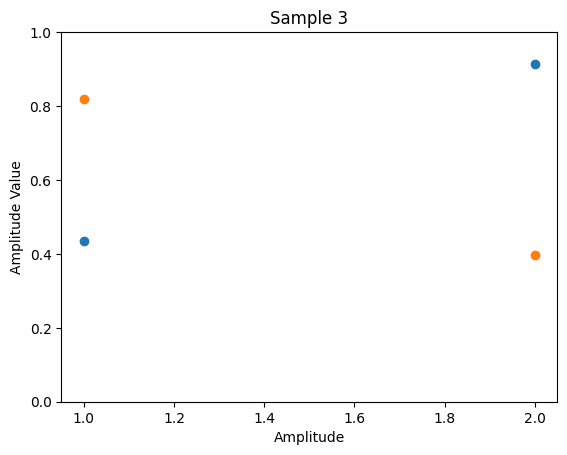

In [201]:
    plt.subplot(1,1,1)
    plt.scatter(Parameters, y_testA[366], label='True')
    plt.scatter(Parameters, predictionsA[366], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Amplitude')
    plt.ylabel('Amplitude Value')
    plt.ylim(0, 1)
    plt.show()



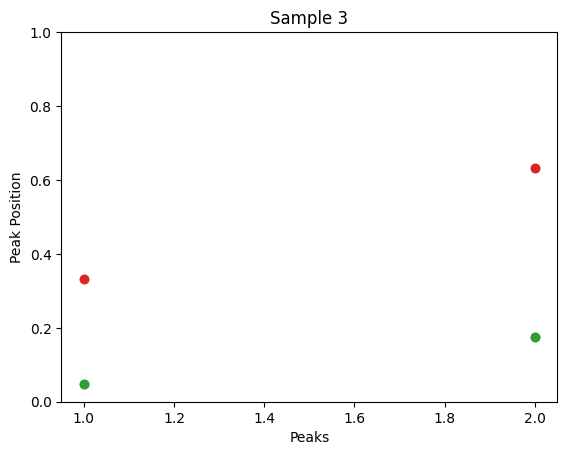

In [203]:

    plt.subplot(1, 1, 1)
    plt.scatter(Parameters, y_testp[366], label='True')
    plt.scatter(Parameters, predictionsp[366], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peaks')
    plt.ylabel('Peak Position')
    plt.ylim(0, 1)
    plt.show()

In [ ]:
print("regression problem>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
# generate dataset
xtoy, ytoy = stdsc.fit_transform(x), stdsc.fit_transform(y)

# build model and train
model = elm.elm(hidden_units=2087, activation_function='sigmoid', random_type='normal', x=xtoy, y=ytoy, C=1, elm_type='reg')  # normal分布效果好
beta, train_score, running_time = model.fit('no_re')
print("regression beta:\n", beta)
print("regression train score:", train_score)
print("regression running time:", running_time)

# test
prediction = model.predict(xtoy)
print("regression result:", prediction.reshape(-1, ))
print("regression score:", model.score(xtoy, ytoy))

# plot
plt.plot(xtoy, ytoy)
plt.plot(xtoy, prediction)
plt.title('xtoy, ytoy')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


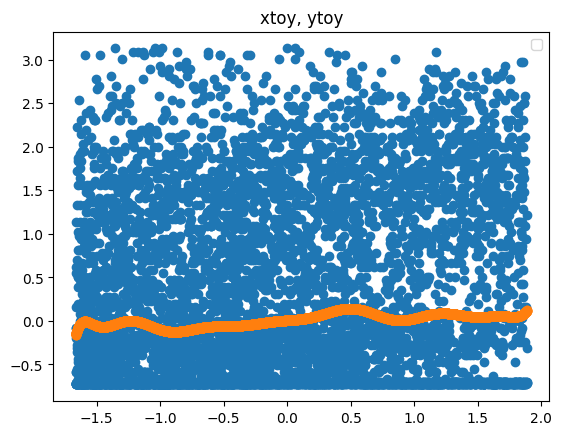

In [32]:
plt.scatter(xtoy, ytoy,c=)
plt.scatter(xtoy, prediction)
plt.title('xtoy, ytoy')
plt.legend()
plt.show()

In [12]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


regression beta:
 [[ 2.19705980e+07]
 [-1.96105683e+08]
 [ 3.39082700e+07]
 [-6.24931809e+07]
 [ 1.07430921e+08]
 [-9.32159447e+07]
 [ 1.46708605e+07]
 [ 6.55019078e+07]
 [ 1.05267884e+07]
 [ 6.87130350e+07]
 [ 2.10352365e+07]
 [ 8.69181499e+07]
 [ 7.04840792e+07]
 [-1.41338139e+07]
 [ 2.42868605e+08]
 [-8.26396664e+07]
 [-1.56935004e+07]
 [ 3.88276093e+06]
 [ 1.86979460e+07]
 [ 5.54363790e+04]
 [-1.99916176e+07]
 [-1.98078560e+08]
 [-6.54131416e+07]
 [-6.78852574e+07]
 [-3.54866789e+07]
 [ 1.13783857e+08]
 [-1.27286082e+08]
 [ 2.56060540e+08]
 [-5.95329410e+07]
 [-1.20646192e+08]
 [-8.40360550e+07]
 [-3.55142887e+07]]
regression train score: 0.9976955775163346
regression running time: 0.0
regression result: [-0.03253025 -0.04380837  0.07533535 ...  0.08093701 -0.04994117
 -0.01908193]
regression score: 0.9976955775163346


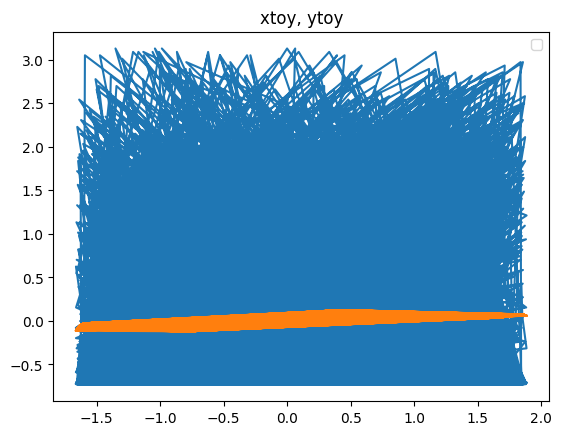

In [13]:
xtoy, ytoy = stdsc.fit_transform(x), stdsc.fit_transform(y)

# build model and train
model = elm.elm(hidden_units=32, activation_function='sigmoid', random_type='normal', x=xtoy, y=ytoy, C=1, elm_type='reg')  # normal
beta, train_score, running_time = model.fit('no_re')
print("regression beta:\n", beta)
print("regression train score:", train_score)
print("regression running time:", running_time)

# test
prediction = model.predict(xtoy)
print("regression result:", prediction.reshape(-1, ))
print("regression score:", model.score(xtoy, ytoy))

# plot
plt.plot(xtoy, ytoy)
plt.plot(xtoy, prediction)
plt.title('xtoy, ytoy')
plt.legend()
plt.show()